In [88]:
# Libraries
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [94]:
# Load metadata
metadata = pd.read_csv('UrbanSound8K.csv')
# Filter only files in fold1/0
folder_path = 'drive/MyDrive/datasets/urbansound/fold1/0'
file_list = os.listdir(folder_path)
print(file_list)

['93567-8-0-1.wav', '93567-8-0-10.wav', '85574-3-0-2.wav', '159742-8-0-12.wav', '93567-8-0-0.wav', '88121-8-2-0.wav', '85574-3-0-12.wav', '85574-3-0-0.wav', '159742-8-0-11.wav', '84249-9-0-8.wav', '83502-0-0-9.wav', '83502-0-0-7.wav', '83502-0-0-8.wav', '83502-0-0-6.wav', '83502-0-0-5.wav', '83502-0-0-3.wav', '83502-0-0-4.wav', '84249-9-0-7.wav', '159742-8-0-10.wav', '84249-9-0-6.wav', '84249-9-0-3.wav', '83502-0-0-2.wav', '84249-9-0-11.wav', '162134-7-0-1.wav', '162134-7-0-0.wav', '159742-8-0-9.wav', '159742-8-0-8.wav', '159742-8-0-7.wav', '99192-4-0-7.wav', '159742-8-0-6.wav', '99192-4-0-55.wav', '99192-4-0-48.wav', '99192-4-0-49.wav', '99192-4-0-47.wav', '99192-4-0-41.wav', '99192-4-0-38.wav', '99192-4-0-54.wav', '99192-4-0-40.wav', '99192-4-0-43.wav', '99192-4-0-52.wav', '99192-4-0-53.wav', '159742-8-0-5.wav', '99192-4-0-33.wav', '99192-4-0-32.wav', '99192-4-0-30.wav', '159742-8-0-4.wav', '99192-4-0-18.wav', '99192-4-0-24.wav', '99192-4-0-20.wav', '99192-4-0-15.wav', '99192-4-0-12.

In [95]:
metadata_fold0 = metadata[
    (metadata['slice_file_name'].isin(file_list))
]

In [97]:
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    return np.mean(mfcc, axis=1)


In [96]:
metadata_fold0

,slice_file_name,fsID,start,end,salience,fold,classID,class
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
10,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn
11,100648-1-2-0.wav,100648,16.699509,17.104837,2,10,1,car_horn
12,100648-1-3-0.wav,100648,17.631764,19.253075,2,10,1,car_horn
13,100648-1-4-0.wav,100648,25.332994,27.197502,2,10,1,car_horn
...,...,...,...,...,...,...,...,...
8704,99192-4-0-52.wav,99192,26.000000,30.000000,1,10,4,drilling
8705,99192-4-0-53.wav,99192,26.500000,30.500000,1,10,4,drilling
8706,99192-4-0-54.wav,99192,27.000000,31.000000,1,10,4,drilling
8707,99192-4-0-55.wav,99192,27.500000,31.500000,1,10,4,drilling


In [98]:
# Extract features for fold1
data = []
for _, row in tqdm(metadata_fold0.iterrows(), total=len(metadata_fold0)):
    path = os.path.join(folder_path, row['slice_file_name'])
    if os.path.exists(path):
        mfcc = extract_mfcc(path)
        data.append([mfcc, row['class']])

100%|██████████| 837/837 [11:06<00:00,  1.26it/s]


In [103]:
# Create DataFrame
df = pd.DataFrame(data, columns=['Features', 'Class'])
X = np.array(df['Features'].tolist())

le = LabelEncoder()
y_encoded = le.fit_transform(df['Class'])
y = to_categorical(y_encoded)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = y.shape[1]


In [104]:
df['Class']

,Class
0,car_horn
1,car_horn
2,car_horn
3,car_horn
4,car_horn
...,...
832,drilling
833,drilling
834,drilling
835,drilling


In [105]:
# Model
model = Sequential([
    layers.Dense(256, activation='relu', input_shape=(50,)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3485 - loss: 1.9725 - val_accuracy: 0.6190 - val_loss: 1.2979
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6772 - loss: 1.0197 - val_accuracy: 0.7798 - val_loss: 0.7620
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7885 - loss: 0.7270 - val_accuracy: 0.8393 - val_loss: 0.5952
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8372 - loss: 0.5633 - val_accuracy: 0.8690 - val_loss: 0.4776
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8180 - loss: 0.5432 - val_accuracy: 0.8095 - val_loss: 0.4727
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8168 - loss: 0.5146 - val_accuracy: 0.8512 - val_loss: 0.3876
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8717 - loss: 0.4105 - val_accuracy: 0.8869 - val_loss: 0.2812
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8710 - loss: 0.3887 - val_accuracy: 0.8929 - val_loss: 0.3250
Ep

In [106]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,394 (220.29 KB)

 Trainable params: 55,626 (217.29 KB)

 Non-trainable params: 768 (3.00 KB)

In [107]:
# Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       1.00      0.95      0.97        19
        car_horn       1.00      0.75      0.86         4
children_playing       0.94      0.75      0.83        20
        dog_bark       0.88      0.95      0.91        22
        drilling       1.00      1.00      1.00        22
   engine_idling       1.00      0.96      0.98        24
        gun_shot       1.00      0.83      0.91         6
      jackhammer       1.00      1.00      1.00        15
           siren       0.77      1.00      0.87        17
    street_music       0.90      0.95      0.92        19

        accuracy                           0.93       168
       macro avg       0.95      0.91      0.93       168
    weighted avg       0.94      0.93      0.93       168



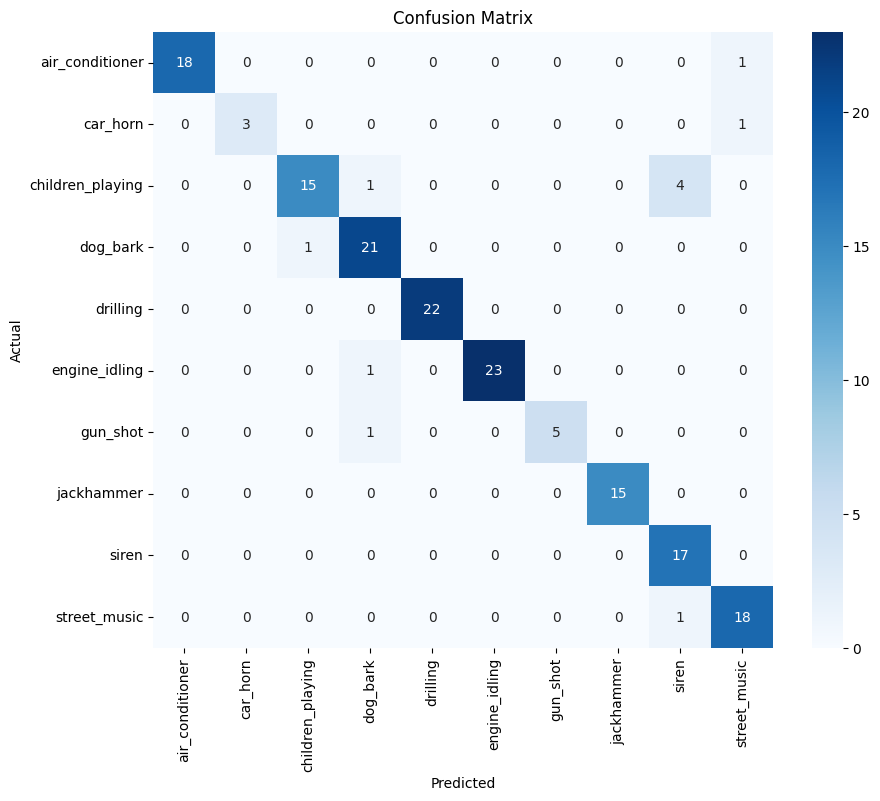

In [108]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=list(range(num_classes)), target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
